# Study on Book Sales
#### Arina Sitnikova

Loading all the necessary libraries:

In [840]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Part 1. Creating recommendations

In [823]:
df = pd.read_csv('part_one_data.csv')
df.head()

,BOOK,DAY_NUMBER,CONSUMER_ID,SALE_PRICE
0,book_6,55,1350,13.99
1,book_5,85,2236,16.99
2,book_4,52,1032,15.99
3,book_5,28,1514,16.99
4,book_5,4,2736,16.99


Taking a quick look at the data - we've got 3509 observations for 7 books.

In [816]:
df.shape

(3509, 4)

In [817]:
df['BOOK'].nunique()

7

Grouping by the book type and iterating through a given range of days, it is possible to deduce whether any changes in the book price occurred:

In [818]:
print("The books for which sale price changed:")
for index, group in df.sort_values(by = 'DAY_NUMBER').groupby('BOOK'):
    group['PRICE_CHANGE'] = group['SALE_PRICE'].diff()
    result = group[(group['PRICE_CHANGE'] != 0) & (group['PRICE_CHANGE'].notna())]
    if not result.empty:
        for i in result['BOOK'].unique():
                print(i)

The books for which sale price changed:
book_2
book_3


To evaluate the success of price change and its effect on sales, there exist numerous metrics. On of the most high-level ones are price effect or quantity effect coefficients. However, we don't have the same number of observations for different prices: for example, for book 2 the price was 13.99 for 74 days and 4.99 for 13 days only. For this reason, we can't calculate the abovementioned effects. 

Other common KPIs include ROI, cost per sale, incremental sales, etc. However, those are impossible to calculate as well since the data contains sale price as the only numeric feature associated with a company's profits.

However, we know the number of days when the price was lowered. Thus, one of the most straightforward approaches is to calculate average daily profits for each sale price based on the number of books sold:

$$AvgDailyProfit_{i, p} = \frac{p_i * NumBooks_{i,p}}{NumDays_{i,p}}$$

where $p$ - is a sale price, $p = [4.99, 13.99]$; $NumBooks$ - number of books of type $i$ sold for given price; $NumDays$ - number of days when the given price was fixed for book $i$; $i = [2, 3]$. 

In [819]:
df_book2 = df[df['BOOK'] == 'book_2'].groupby('SALE_PRICE').agg({'SALE_PRICE': 'sum', 'DAY_NUMBER': 'nunique'}).rename(columns={'SALE_PRICE': 'profit', 'DAY_NUMBER': 'num_day'})
df_book2['avg_profit_book2'] = df_book2['profit']/df_book2['num_day']
df_book3 = df[df['BOOK'] == 'book_3'].groupby('SALE_PRICE').agg({'SALE_PRICE': 'sum', 'DAY_NUMBER': 'nunique'}).rename(columns={'SALE_PRICE': 'profit', 'DAY_NUMBER': 'num_day'})
df_book3['avg_profit_book3'] = df_book3['profit']/df_book3['num_day']
avg_profit = pd.merge(round(df_book2['avg_profit_book2'].to_frame(), 2), round(df_book3['avg_profit_book3'].to_frame(),2), left_index=True, right_index=True)

Thus, we can observe that for book 2 the price change was not successful: in case of high prices, the average daily profits were approximately two times higher compared to the profits given at low prices. On the other hand, we can notice quite the opposite effect for book 3: when the price was 13.99, the average daily profits were just under 70, reaching the height of about 320 as the price went down to become 4.99.

In [825]:
avg_profit

,avg_profit_book2,avg_profit_book3
SALE_PRICE,,
4.99,14.97,319.36
13.99,31.95,69.03


Then we will try to identify any books that appear to be closely related to each other. 

We can notice that each consumer bought up to three different books:

In [826]:
df.groupby('CONSUMER_ID')['BOOK'].nunique().sort_values(ascending=False).head()

CONSUMER_ID
2349    3
2533    3
1842    3
308     3
2190    3
Name: BOOK, dtype: int64

We do not know whether any given consumer liked the books they purchased - there is no extra data regarding book rating or reviews. Nor do we know anything about the customers themselves (age, occupation, etc.). The only thing that we know is which books they ended up buying. 

Using this knowledge, we can assume that, for example, if several people purchased both book $i$ and book $j$, then these books might be similar. That being said, if a new customer decided to buy book $i$, we might want to recommend them book $j$ as well. 

Thus, in our case, we can apply collaborative filtering which is based on patterns in a user’s behaviour or activity. Since we do not have any data on books except for the price (which is not a unique feature), we can't use item-based filtering which is based on the similarity between the items. However, user-based filtering might be the method of our choice because we can find users with similar consumption patterns.

One of the most common algorithms for collaborative filtering is k-Nearest Neighbors. kNN finds clusters of similar users based on a given feature - usually rating. However, since we don't have such a feature, we will just use a binary variable indicating whether a consumer purchased book $i$.  

The first thing to do is to convert our data to a 2D matrix containing. It is also should be noted that some of the consumers bought several copies of the same books. That leaves us with several duplicated rows since for now, we will only take into account two factors - consumer id and book type. Therefore, it is necessary to drop duplicates beforehand.

In [827]:
df1 = df[['BOOK', 'CONSUMER_ID']]
df1 = df1.drop_duplicates()
df1['indicator'] = 1

In [831]:
R = df1.pivot(index='CONSUMER_ID', columns='BOOK', values='indicator').fillna(0)
R.head()

BOOK,book_1,book_2,book_3,book_4,book_5,book_6,book_7
CONSUMER_ID,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [832]:
X = R.T

The matrix contains a lot of 0's. Therefore, it is more efficient to transform it into a sparse matrix.

In [833]:
from scipy.sparse import csr_matrix
mat_features = csr_matrix(X.values)

Then we fit the model and obtain the nearest neighbours for each book:

In [834]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1)
model_knn.fit(mat_features)
distances, indices = model_knn.kneighbors(X.iloc[0, :].values.reshape(1, -1), n_neighbors = 4)

Below are seven sets, each consisting of three books which could be related to book $i$, $i \in [1,7]$, according to kNN algorithm:

In [837]:
for i in range(0, 7):
    for j in range(0, 4):
        distances, indices = model_knn.kneighbors(X.iloc[i, :].values.reshape(1, -1), n_neighbors = 4)
        if j == 0:
            #print('Recommendation for book_{0}:'.format(X.index[j]))
            print('Recommendation for book_{0}:'.format(i+1))
        else:
            print('{0}. {1}, distance - {2}'.format(j, X.index[indices.flatten()[j]], round(distances.flatten()[j], 4)))

Recommendation for book_1:
1. book_4, distance - 0.9644
2. book_5, distance - 0.9893
3. book_6, distance - 0.9914
Recommendation for book_2:
1. book_7, distance - 0.8014
2. book_5, distance - 0.9821
3. book_3, distance - 0.9837
Recommendation for book_3:
1. book_7, distance - 0.9675
2. book_2, distance - 0.9837
3. book_6, distance - 0.9899
Recommendation for book_4:
1. book_1, distance - 0.9644
2. book_5, distance - 0.9902
3. book_3, distance - 0.9981
Recommendation for book_5:
1. book_2, distance - 0.9821
2. book_7, distance - 0.9876
3. book_1, distance - 0.9893
Recommendation for book_6:
1. book_3, distance - 0.9899
2. book_1, distance - 0.9914
3. book_7, distance - 0.9947
Recommendation for book_7:
1. book_2, distance - 0.8014
2. book_3, distance - 0.9675
3. book_5, distance - 0.9876


What we can notice is that the majority of books have a distance of at least 0.95 to the closest neighbour which might indicate that the similarity is doubtful. However, the distance between book 2 and book 7 is 0.8; thus, these books are most likely to be related.

Another widely used method of collaborative filtering is matrix factorization. We will use the singular value decomposition (SVD). The algorithm uses the same 2D matrix as before.

In [501]:
import sklearn
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=5, random_state=17)
resultant_matrix = SVD.fit_transform(X)

We fit the model and calculate the Pearson’s R correlation coefficient for every book pair in our final matrix. 

In [841]:
corr_mat = np.corrcoef(resultant_matrix)
#pd.DataFrame(corr_mat, columns = ['Book 1', 'Book 2', 'Book 3', 'Book 4', 'Book 5', 'Book 6', 'Book7'])
book_set = ['Book 1', 'Book 2', 'Book 3', 'Book 4', 'Book 5', 'Book 6', 'Book7']

The correlation plot below shows which books have high correlation coefficients and therefore might be related to each other.

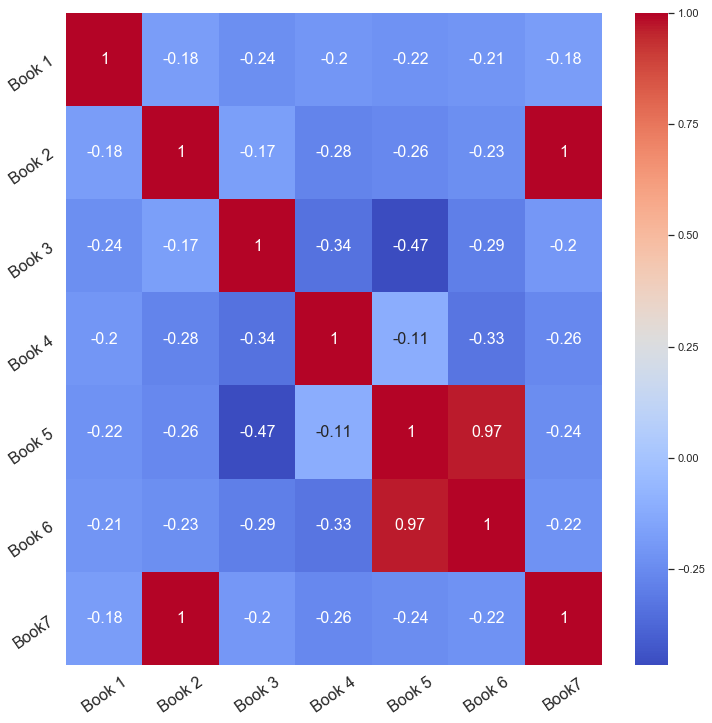

In [975]:
fig = plt.figure(figsize=(12, 12));
heat_map = sns.heatmap(pd.DataFrame(corr_mat, index = book_set, columns = book_set), annot = True, annot_kws={"size": 16}, cmap='coolwarm')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=35, size = 16)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=35, size = 16)
plt.show()

In [976]:
fig = heat_map.get_figure()
fig.savefig('SVD_map.png') 

Of course, many books are uncorrelated. Those that have the correlation coefficient of at least 0.7 are presented below:

In [844]:
book_num = R.columns
for i in range(0, 7):
    corr_list = list(book_num[(corr_mat[i]<=1) & (corr_mat[i] >= 0.7)])
    final = [x for x in corr_list if book_num[i] not in x]
    print('Book {} can be related to:'.format(i+1), final)

Book 1 can be related to: []
Book 2 can be related to: ['book_7']
Book 3 can be related to: []
Book 4 can be related to: []
Book 5 can be related to: ['book_6']
Book 6 can be related to: ['book_5']
Book 7 can be related to: ['book_2']


Both kNN and SVD methods indicated that book 2 and book 7 might be closely related. Therefore, if we introduce this recommender system, it will recommend that a consumer purchase book 7 if they already decided to buy book 2 and the other way around. 

When it comes to other books, kNN and SVD produced different results. The SVD-based system will recommend book 5 and book 6 together. On the other hand, the kNN-based system would suggest buying book 2 together with book 5.

Nonetheless, it has already been mentioned that the data we have got is not enough. Current models are expected to perform poorly. To increase a chance of recommending books successfully, any feedback produced by the consumer in the past could be used; for example, rating (eg 1 to 5) or text review (which could be used for sentiment analysis). Any data on the consumer would also be helpful - age, occupation. Purchase history can also tell a lot; for example, if we know what type of books (fiction, non-fiction, different genres, etc) a consumer used to buy in the past, it might be easier to deduce which books they would not like for sure.

## Part 2. Identifying determinants of sales

In [862]:
df_train = pd.read_csv('part_two_sales_train.csv')
df_test = pd.read_csv('part_two_sales_validation.csv')
df_meta = pd.read_csv('part_two_metadata.csv')

In [978]:
df_train.head()

,TITLE,TITLE_WEEK,CAL_WEEK,SALES
0,128529,1,41,209
1,126193,1,33,249
2,148651,974,51,256
3,135491,3078,31,223
4,138148,6,2,319


In [979]:
df_meta.head()

,TITLE,FORMAT,SUBJECT,CATEGORY,DIVISION,STATUS
0,168611,MM,NFC,TRU002000,12,IP
1,152640,TR,FIC,FIC044000,29,OS
2,114404,HC,FIC,FIC030000,29,IP
3,175471,HC,NFC,CKB085000,97,IP
4,185266,MM,FIC,FIC030000,73,IP


In [846]:
print(df_train.shape)
print(df_test.shape)
print(df_meta.shape)

(1200, 4)
(400, 4)
(1000, 6)


The data (both train and test) needs to be transformed at first. The original data contains both current and future sales. However, since we need to predict future sales based on other variables, these values will be used as a dependent variable in the regression problem. In addition, we append additional metadata to sales data in order to create an initial matrix of explanatory variables. 

In [863]:
train_sorted = df_train.sort_values(by = 'CAL_WEEK')
dftr1 = train_sorted.groupby('TITLE').nth(0).reset_index()
dftr2 = train_sorted.groupby('TITLE').nth(1).reset_index()[['TITLE', 'SALES']]
dftr2.columns = ['TITLE', 'FUTURE_SALES']
dftrain = pd.merge(dftr1, dftr2, on='TITLE')
train = pd.merge(dftrain, df_meta, on='TITLE')

In [864]:
test_sorted = df_test.sort_values(by = 'CAL_WEEK')
dftest1 = test_sorted.groupby('TITLE').nth(0).reset_index()
dftest2 = test_sorted.groupby('TITLE').nth(1).reset_index()[['TITLE', 'SALES']]
dftest2.columns = ['TITLE', 'FUTURE_SALES']
dftest = pd.merge(dftest1, dftest2, on='TITLE')
test = pd.merge(dftest, df_meta, on='TITLE')

Checking for null values and duplicated rows - there are none in either dataset:

In [850]:
train[train.isnull().apply(lambda x: max(x), axis=1)]

,TITLE,CAL_WEEK,SALES,TITLE_WEEK,FUTURE_SALES,FORMAT,SUBJECT,CATEGORY,DIVISION,STATUS


In [851]:
test[test.isnull().apply(lambda x: max(x), axis=1)]

,TITLE,CAL_WEEK,SALES,TITLE_WEEK,FUTURE_SALES,FORMAT,SUBJECT,CATEGORY,DIVISION,STATUS


In [852]:
train[train.duplicated()]

,TITLE,CAL_WEEK,SALES,TITLE_WEEK,FUTURE_SALES,FORMAT,SUBJECT,CATEGORY,DIVISION,STATUS


In [853]:
test[test.duplicated()]

,TITLE,CAL_WEEK,SALES,TITLE_WEEK,FUTURE_SALES,FORMAT,SUBJECT,CATEGORY,DIVISION,STATUS


In [849]:
train.head()

,TITLE,CAL_WEEK,SALES,TITLE_WEEK,FUTURE_SALES,FORMAT,SUBJECT,CATEGORY,DIVISION,STATUS
0,100268,22,858,1,282,TR,NFC,BIO026000,29,IP
1,100300,38,743,1,219,TR,FIC,CGN004080,EK,IP
2,100338,8,274,1,107,HC,FIC,FIC006000,63,IP
3,100402,43,456,1,139,TR,NFC,HIS006000,89,IP
4,101714,51,202,171,166,TR,NFC,HIS002020,9X,IP


Then we'll proceed with feature engineering for train data. There are three different formats of the book, and the data contains a lot of observations for each one. This might be a useful feature, therefore we create dummies (in both train and test data) to get rid of the categorical format: 

In [854]:
train['FORMAT'].value_counts()

HC    292
TR    241
MM     67
Name: FORMAT, dtype: int64

In [865]:
train = pd.get_dummies(train, columns=['FORMAT'])
test = pd.get_dummies(test, columns=['FORMAT'])

There are also three subjects of the book. Within each subject, there are several categories that produce high cardinality (a large number of unique values). It is highly likely that the model will overfit to the training data if we use data on categories because it is too detailed to generalize well. Thus, we'll ignore the CATEGORY column but nevertheless create dummies for the SUBJECT column.

In [866]:
train['SUBJECT'].value_counts()

FIC    228
NFC    205
JUV    167
Name: SUBJECT, dtype: int64

In [867]:
train['CATEGORY'] = train['CATEGORY'].str[0:3]
train.groupby('SUBJECT')['CATEGORY'].value_counts().head(15)

SUBJECT  CATEGORY
FIC      FIC         216
         CGN          12
JUV      JUV         117
         JNF          31
         YAF          19
NFC      CKB          41
         BIO          20
         BUS          18
         SEL          18
         SOC          13
         HEA          12
         HUM          10
         PSY           9
         TRU           9
         GAM           8
Name: CATEGORY, dtype: int64

In [868]:
train = pd.get_dummies(train, columns=['SUBJECT'])
test = pd.get_dummies(test, columns=['SUBJECT'])

If we check the STATUS column, we can notice that roughly 90% of the observations have 'IP' as a value for this factor while the remaining 10% have any of the other 7 labels. Thus, there is no need in creating 8 dummy variables. We can create just one - a binary variable indicating whether status = 'IP' or not.

In [869]:
train['STATUS'].value_counts()

IP    536
HT     37
NR      8
OS      7
XD      5
OP      3
RM      3
RI      1
Name: STATUS, dtype: int64

In [870]:
train['STATUS_IP'] = np.where(train['STATUS'] == 'IP', 1, 0)
test['STATUS_IP'] = np.where(test['STATUS'] == 'IP', 1, 0)

Finally, the DIVISION variable also contains a lot of unique values (high cardinality problem) and does not seem to be informative; therefore, it won't be used in the analysis.

In [873]:
train['DIVISION'].nunique()

54

Before creating any model, let's take a look at the pairplot of continuous variables which would show both joint relationships and histograms for univariate distributions:

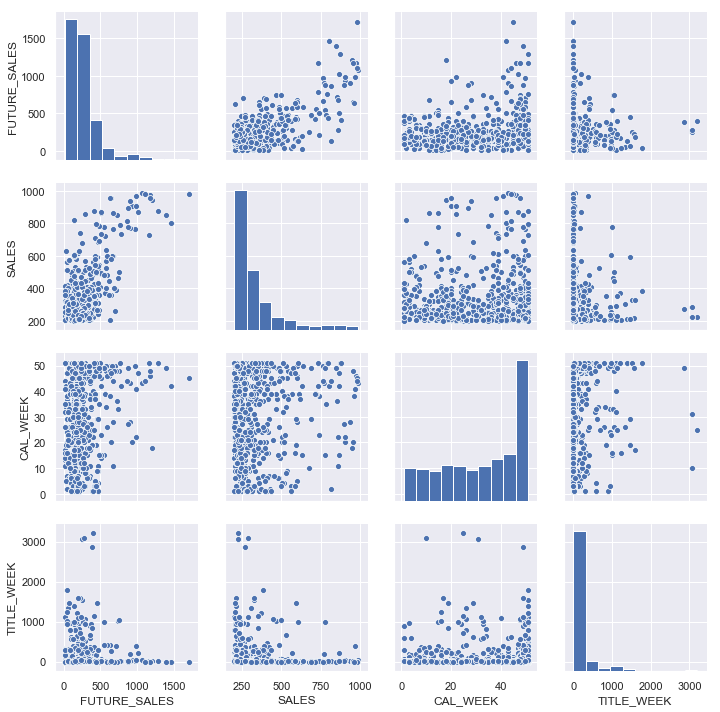

In [980]:
pairplot = sns.pairplot(train[['FUTURE_SALES', 'SALES', 'CAL_WEEK', 'TITLE_WEEK']]);

In [982]:
fig2 = pairplot.fig
fig2.savefig('pairplot.png') 

What we can notice is that there is a possible linear dependence between current and future sales (though the majority of points are in the lower-left corner). No linear dependence is observed with regards to other explanatory variables.

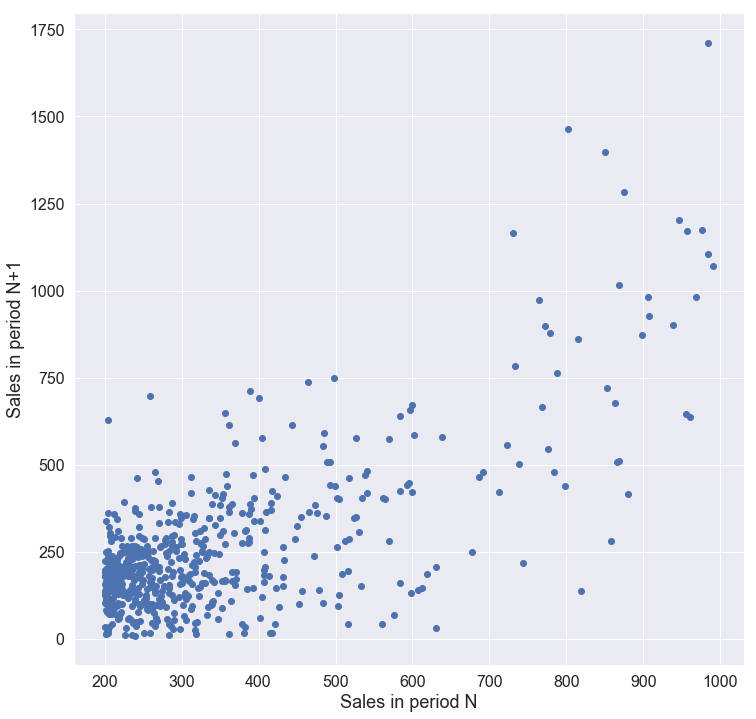

In [990]:
fig = plt.figure(figsize=(12, 12));
plt.scatter(train['SALES'],train['FUTURE_SALES']);
plt.xlabel('Sales in period N', size = 18)
plt.xticks(size = 16)
plt.ylabel('Sales in period N+1', size = 18)
plt.yticks(size = 16)
#plt.title('Relationship between current and future sales', size = 22);
plt.savefig('scatter.png')

Moving on to machine learning techniques, we will consider the following features for the analysis:

In [879]:
features_to_include = ['CAL_WEEK', 'SALES', 'TITLE_WEEK', 'STATUS_IP', 'SUBJECT_FIC', 'SUBJECT_JUV',
                      'SUBJECT_NFC', 'FORMAT_HC', 'FORMAT_TR']

In [880]:
X_train = train[features_to_include]
X_test = test[features_to_include]

y_train = train['FUTURE_SALES']
y_test = test['FUTURE_SALES']

The most direct approach is linear regression. However, it is necessary to check for multicollinearity (substantial correlation between different explanatory variables) at first since it can cause inconsistent estimators. We'll do that by taking a look at the correlation matrix:

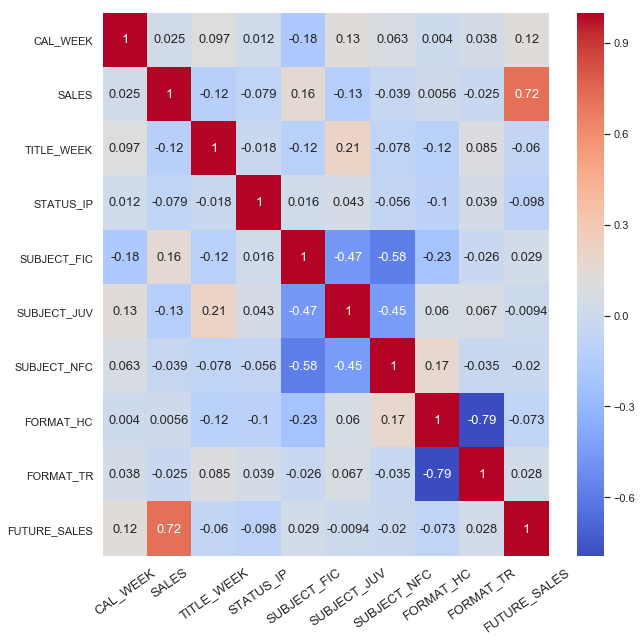

In [1000]:
plt.figure(figsize=(10,10))
cor = final_df.corr()
heat_map2 = sns.heatmap(cor, annot=True, annot_kws={"size": 13}, cmap='coolwarm')
heat_map2.set_xticklabels(heat_map2.get_xticklabels(), size = 13, rotation=35)
heat_map.set_yticklabels(heat_map.get_yticklabels(), size = 18)
plt.show()

In [1001]:
fig3 = heat_map2.get_figure()
fig3.savefig('multicor_map.png') 

We can notice a high negative correlation between:

1. Hardcover and trade paperback book formats
2. Fiction and non-fiction books;

The coefficient of correlation for fiction/kids and non-fiction/kids books is also substantial though tolerable since it does not exceed 0.5. Therefore, we can't use the ordinary linear regression model. It is necessary to introduce regularization if we decide to use all the features.

There is also a high correlation between current and future sales which supports the assumption stated earlier regarding linear dependence between the variables.

In [883]:
cor_target = abs(cor["FUTURE_SALES"])
cor_target[cor_target>0.3]

SALES           0.71899
FUTURE_SALES    1.00000
Name: FUTURE_SALES, dtype: float64

As a next step, we introduce the feature selection algorithm which is based on entropy estimation from k-nearest neighbours distances and used to evaluate feature importances with the help of mutual information value.

The model suggests that almost every feature is completely useless (i.e. dependent and explanatory variables are independent) in predicting future sales. Current sales (as expected) are the most important feature while calendar week and indicator of non-fiction type of the book are slightly influential as well. If we use these three features only, that eliminates the multicollinearity problem and multiple linear regression can be used.

In [884]:
from sklearn import feature_selection
feature_rank = feature_selection.mutual_info_regression(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

In [889]:
feature_rank_df = pd.DataFrame(list(zip(features_to_include, feature_rank)), columns=['Feature', 'Score'])
feature_rank_df.sort_values(by='Score', ascending = False)

,Feature,Score
1,SALES,0.271259
0,CAL_WEEK,0.022451
6,SUBJECT_NFC,0.002828
2,TITLE_WEEK,0.000000
3,STATUS_IP,0.000000
4,SUBJECT_FIC,0.000000
5,SUBJECT_JUV,0.000000
7,FORMAT_HC,0.000000
8,FORMAT_TR,0.000000


In [890]:
useful_feat = [x for x in feature_rank_df[feature_rank_df['Score'] > 0]['Feature']]

##### Linear Regression Model

In [891]:
lr_model = sk.linear_model.LinearRegression()
model = lr_model.fit(X_train[useful_feat], y_train)

In [893]:
print("The coefficient of determination R^2 for train data is", round(model.score(X_train[useful_feat], y_train), 4))
print("The coefficient of determination R^2 for test data is", round(model.score(X_test[useful_feat], y_test), 4))

The coefficient of determination R^2 for train data is 0.5315
The coefficient of determination R^2 for test data is 0.5033


Unfortunately, only 53% and 50% of the variance is explained for train and test data respectively. This is quite a poor result; however, it could be expected given that it is the simplest model for regression problems.

##### Lasso Regression Model

Since we did not take into account many features, it might be worth trying to include all of them. However, it was mentioned that this brings multicollinearity. That's why it is necessary to introduce regularization. Lasso is one of the models that is used to address over-fitting and feature selection.

In [911]:
LassoReg = sk.linear_model.Lasso(alpha = 0.5)
lassomod = LassoReg.fit(X_train, y_train)

In [912]:
print("The coefficient of determination R^2 for train data is", round(lassomod.score(X_train, y_train), 4))
print("The coefficient of determination R^2 for test data is", round(lassomod.score(X_test, y_test), 4))

The coefficient of determination R^2 for train data is 0.5556
The coefficient of determination R^2 for test data is 0.5177


The $R^2$ coefficient became just a bit higher yet it is still rather low for both data sets.

While linear regression is one of the most common methods, it is not as flexible because it can't follow non-linear dependencies. If we use more complex methods, there is a high chance we'll be able to identify trends and patterns better.

##### Gradient Boosting

Gradient Boosting is considered to be powerful. It builds many decision trees in series, where the subsequent model is built on the error from the previous model. In this configuration, additional models are fit on the effects that were not captured in the previous model. GB is a tree-based model and hence does not require feature scaling. It is quite hard to determine the best parameters for this method; that's why GridSearchCV will be performed.

In [927]:
parameters = {'max_depth': list(range(1, 15)), 'min_samples_leaf': list(range(1,10))}

In [928]:
from sklearn.ensemble import GradientBoostingRegressor

In [929]:
gbr = GradientBoostingRegressor(n_estimators=100)
gcv = GridSearchCV(gbr, parameters, n_jobs = -1, cv = 5)
gcv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [930]:
gcv.best_params_

{'max_depth': 3, 'min_samples_leaf': 9}

In [931]:
gbm = GradientBoostingRegressor(max_depth = 3, min_samples_leaf = 9)
gbm.fit(X_train, y_train)
print('The coefficient of determination R^2 for train data is', round(gbm.score(X_train, y_train), 4))
print('The coefficient of determination R^2 for test data is', round(gbm.score(X_test, y_test), 4))

The coefficient of determination R^2 for train data is 0.8221
The coefficient of determination R^2 for test data is 0.6384


With Gradient Boosting, we reached some improvements and reached the highest score among all the models used. However, it is clear that the model overfits - there is almost a 20% difference in the $R^2$ score. Apparently, we don't have as many features that would contain enough information for an algorithm to learn effectively and predict quite accurately - thus, even the boosting model had a lot of errors. 

Furthermore, the Gradient Boosting model has a great advantage over many other models - it provides the most important features. The figure below shows which variables turned out to be the greatest contributors; those are current sales, calendar week, title week (length of the time since the book was published). Features associated with subject and format appeared to be the least useful.

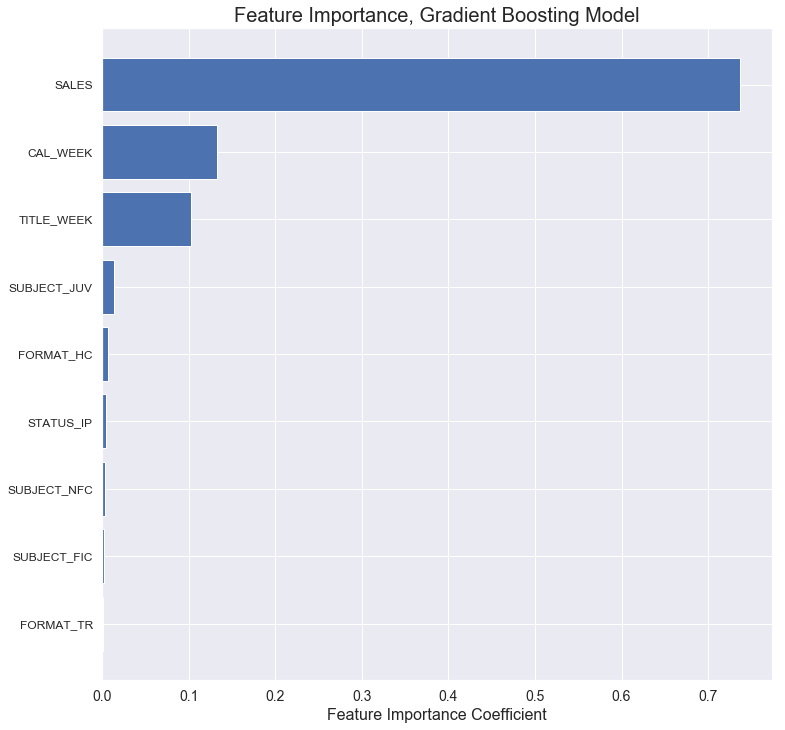

In [1010]:
gbm_feat_importances = pd.DataFrame(list(zip(features_to_include,gbm.feature_importances_)), columns=['Feature','Importance'])
gbm_feat_importances.sort_values(by='Importance', inplace=True)
plt.figure(figsize=[12,12])
plt.xlabel('Feature Importance Coefficient', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 12)
plt.title('Feature Importance, Gradient Boosting Model', fontsize = 20)
plt.barh(gbm_feat_importances['Feature'],gbm_feat_importances['Importance']);
plt.savefig('feat.png')

Furthermore, we can calculate errors using test data only. First, we predict future sales and then compare the outcome with real sales.

In [935]:
predictions = gbm.predict(X_test)

In [936]:
error_df = pd.concat([test[['TITLE', 'FUTURE_SALES']], round(pd.DataFrame(predictions, columns = ['SALES_PREDICTION']), 2)], axis = 1)
error_df['ERROR'] = abs(error_df['FUTURE_SALES'] - error_df['SALES_PREDICTION']) 
error_df = error_df.sort_values(by = 'ERROR', ascending=False)

Below is the table showing ten books which have the largest error:

In [937]:
error_df.head(10)

,TITLE,FUTURE_SALES,SALES_PREDICTION,ERROR
111,150091,1071,517.22,553.78
120,155474,486,906.75,420.75
29,114404,21,425.00,404.00
28,114253,870,1202.97,332.97
184,189644,128,425.84,297.84
179,187982,12,299.11,287.11
90,140114,476,191.67,284.33
115,152873,636,361.63,274.37
10,106570,12,282.13,270.13
45,123504,150,414.95,264.95


Let's take a look at the values of the explanatory variables for those books:

In [938]:
titles = error_df.head(10)['TITLE']

In [940]:
test.drop(['CATEGORY', 'DIVISION', 'STATUS'], axis = 1).loc[test['TITLE'].isin(list(titles))]

,TITLE,CAL_WEEK,SALES,TITLE_WEEK,FUTURE_SALES,FORMAT_HC,FORMAT_MM,FORMAT_TR,SUBJECT_FIC,SUBJECT_JUV,SUBJECT_NFC,STATUS_IP
10,106570,37,342,3397,12,1,0,0,0,1,0,1
28,114253,50,921,7,870,0,0,1,1,0,0,1
29,114404,38,830,1,21,1,0,0,1,0,0,1
45,123504,45,594,6,150,0,0,1,0,0,1,1
90,140114,25,248,13,476,1,0,0,0,1,0,1
111,150091,13,792,10,1071,0,0,1,1,0,0,1
115,152873,47,421,4,636,1,0,0,0,0,1,1
120,155474,30,920,9,486,0,1,0,1,0,0,1
179,187982,7,330,834,12,0,0,1,0,1,0,1
184,189644,24,587,6,128,0,0,1,0,0,1,1


At first sight, these books have nothing in common when it comes to explanatory variables. However, we can notice a huge difference between current and future sales. So, these books experienced an extremely sharp increase/decrease in sales in period N+1 which the model was not able to catch. We already know that other explanatory variables are not as useful in predicting; therefore, they could hardly contribute to the extent of errors.  

Having done some research, there are several factors which we suppose could have made a difference in the results.

Now we don't know anything about authors. The visibility/popularity might be an important feature. Also, the previous sales of an author (not just one particular book) over a reasonable time span (i.e. a year) can be a good feature. GB model indicated that calendar week is somewhat important. Since the year is unknown, it is difficult to create other time features such as month or season; however, their explanation power is likely to be higher because more books might be sold during holidays. 
